<a href="https://colab.research.google.com/github/gnganesh99/BO-for-AutoSTM/blob/main/SPM_Simulator_Tip_Deconvolution_ResNetmodule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Made by Richard (Yu) Liu (2024) https://github.com/RichardLiuCoding?tab=repositories

# Import packages

In [1]:
# !pip install botorch
# !pip install gpytorch
!pip install spmsimu

In [2]:
# Simulator related packages

import numpy as np
import scipy as sp
# from numba import jit, njit, prange
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import random

# from spmsimu.simulator import *
from spmsimu.simulator import *


In [ ]:
# # AC-BO related packages

# import torch

# from botorch.fit import fit_gpytorch_mll
# from botorch.utils import standardize

# from botorch.models import SingleTaskGP
# from gpytorch.mlls import ExactMarginalLogLikelihood
# from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, LogExpectedImprovement
# from gpytorch.distributions import MultivariateNormal
# import gpytorch

# import warnings
# warnings.filterwarnings('ignore')

# from jax.lib import xla_bridge

# print(xla_bridge.get_backend().platform)

In [3]:
# Download example data

!gdown 1lDPXw0V6JoITDDFOHudSaOFSP478Afdm
!gdown 1LGvIhgtq63sosehbtDy0KIoOHf6nPEnV

Downloading...
From: https://drive.google.com/uc?id=1lDPXw0V6JoITDDFOHudSaOFSP478Afdm
To: /content/topo.txt
100% 1.64M/1.64M [00:00<00:00, 54.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LGvIhgtq63sosehbtDy0KIoOHf6nPEnV
To: /content/droplets.npy
100% 2.10M/2.10M [00:00<00:00, 122MB/s]


# Tutorials to SpmSimu

## Generate ground-truth patterns

In [6]:
print(generate_pattern.__doc__)


    Generate ground-trutn patterns for scan simulation.
    
    Inputs:
        nx - int: number of pixels along x direction
        ny - int: number of pixels along y direction
        pattern - string: choose between "checkerboard", "spiral", and "atomic"
        num - int: number of features (boxes, spirals, or atoms) in the pattern
        turns - int: controls the curvature of spirals (only for "spiral")
        show - boolean: if True, the generated pattern will be displayed
        
    Output:
        pattern_map - ndarray: 2D map with ground-truth patterns
    


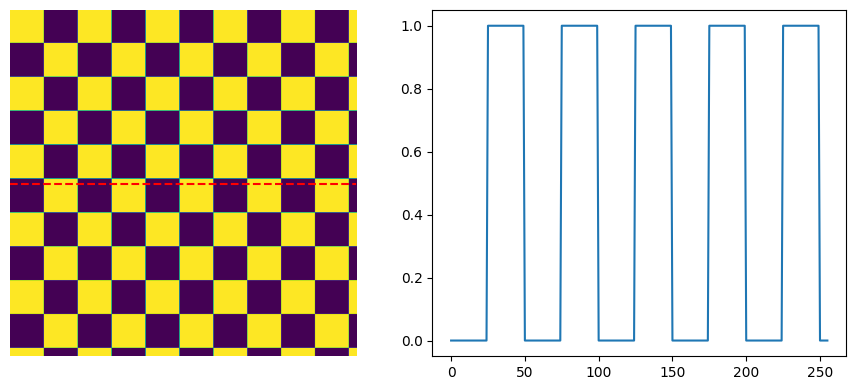

In [7]:
# Generate the checkerboard pattern
checkerboard = generate_pattern(nx=256, ny=256, pattern='checkerboard', num=10, show=True)


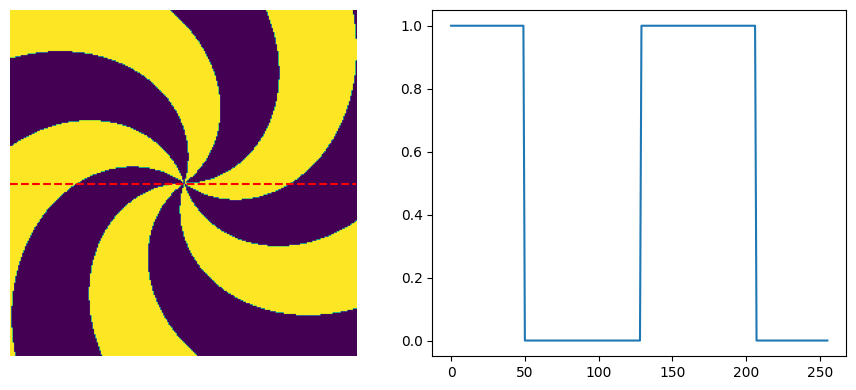

In [8]:
spiral = generate_pattern(nx=256, ny=256, pattern='spiral', num=10, turns=5, show=True)


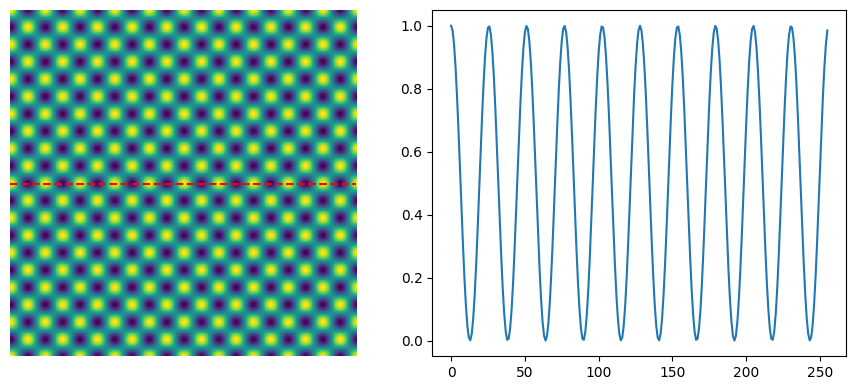

In [9]:
atomic = generate_pattern(nx=256, ny=256, pattern='atomic', num=10, show=True)


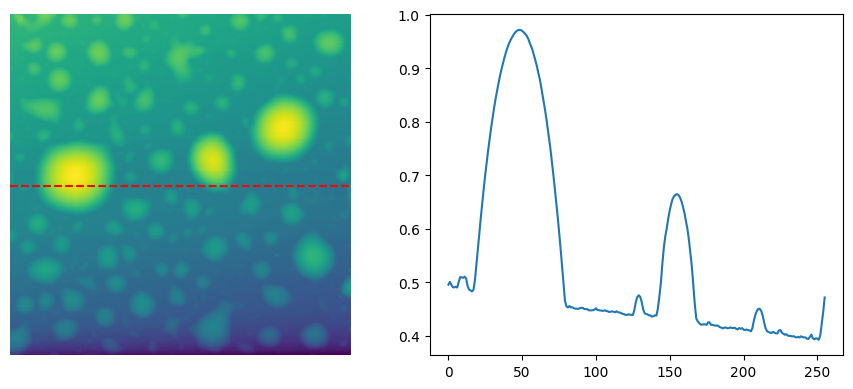

In [11]:
data = np.load('droplets.npy')

droplets = normalize(data[0], center=False)

nx, ny = np.shape(droplets)

fig, ax = plt.subplots(1, 2, figsize=[9,4])
ax[0].imshow(droplets)
ax[0].axhline(nx // 2, linestyle='--', color='r')
ax[0].axis('off')
ax[1].plot(droplets[nx//2])
plt.tight_layout()

## Generate realistic tip-shape

### Ideal tip

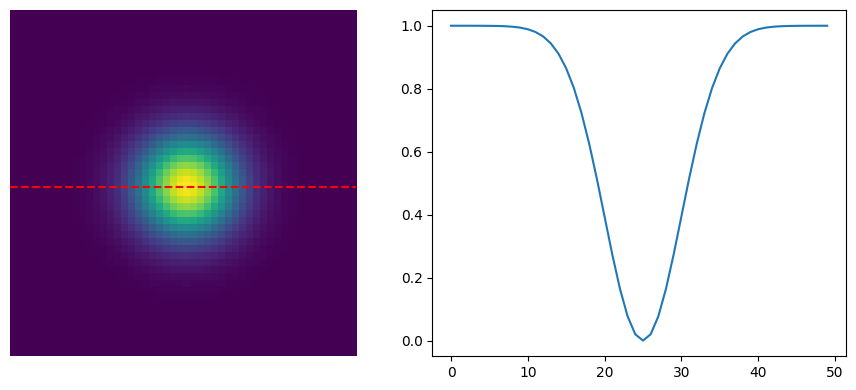

In [12]:
kernel_size = 50 # size of kernel in pixels
wx = 5   # x width of the probe in pixels
wy = 5   # y width of the probe in pixels

tip_ideal = generate_tip_kernel(kernel_size=50, wx=5, wy=5)

nx, ny = np.shape(tip_ideal)
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(tip_ideal)
ax[0].axhline(nx//2, color='r', linestyle='--')
ax[0].axis('off')
ax[1].plot(1-tip_ideal[nx//2])
plt.tight_layout()

### Blunt tip

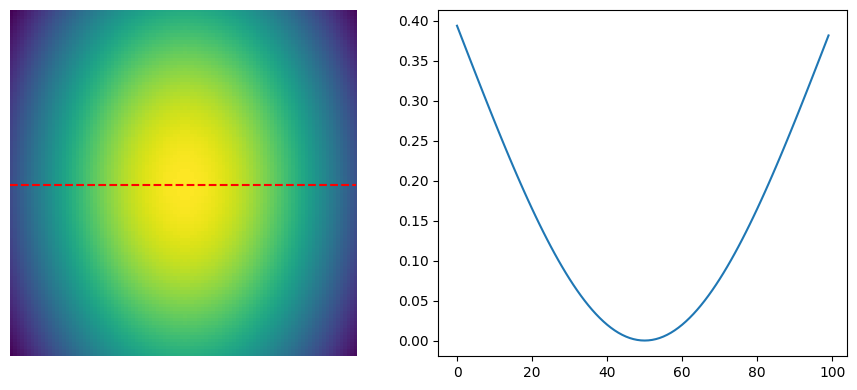

In [13]:
kernel_size = 100 # size of kernel in pixels
wx = 50   # x width of the probe in pixels
wy = 75   # y width of the probe in pixels

tip_blunt = generate_tip_kernel(kernel_size, wx, wy)

nx, ny = np.shape(tip_blunt)
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(tip_blunt)
ax[0].axhline(nx//2, color='r', linestyle='--')
ax[0].axis('off')
ax[1].plot(1-tip_blunt[nx//2])
plt.tight_layout()

### Double-tip

In [14]:
print(generate_doubletip_kernel.__doc__)


    Generate the kernel for double tip, with tip1: [x_width, y_width, tip_height]
    The two tips are separated by offset.
    Everything is in the unit of pixels.
    


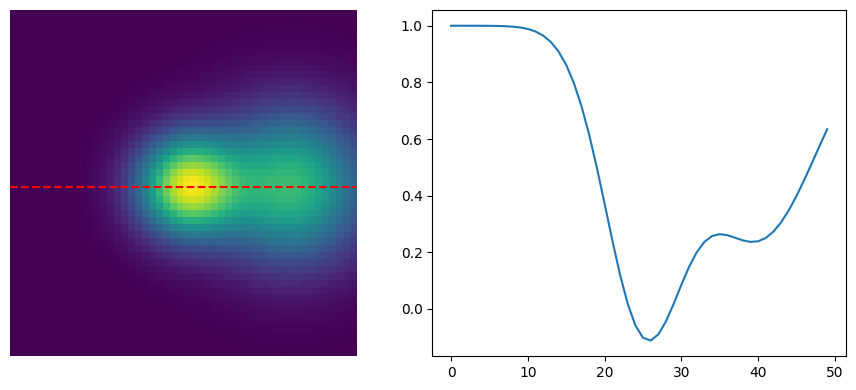

In [15]:
kernel_size = 50
wx1 = 5   # x width of the probe 1
wy1 = 5   # y width of the probe 1
amp1 = 1  # amplitude for probe 1

wx2 = 7.5   # x width of the probe 2
wy2 = 7.5   # y width of the probe 2
amp2 = 0.75  # amplitude for probe 2

offset = [15, 0] # this one controls the separation of two tips

tip_double = generate_doubletip_kernel(kernel_size=kernel_size, offset=offset,tip1=[wx1, wy1, amp1], tip2=[wx2, wy2, amp2])
nx, ny = np.shape(tip_double)
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(tip_double)
ax[0].axhline(nx//2, color='r', linestyle='--')
ax[0].axis('off')
ax[1].plot(1-tip_double[nx//2])
plt.tight_layout()

## Adding the effect of controlling parameters

In [16]:
# generate ground-truth patterns and ideal tip shape
checkerboard = generate_pattern(nx=256, ny=256, pattern='checkerboard', num=10, show=False)

tip_ideal = generate_tip_kernel(kernel_size=50, wx=2.5, wy=2.5)

In [17]:
print(scan.__doc__)


    Generate realistic scan images based on the ground truth image, tip shape kernel, and scanning parameters.
    Input:
        image      - ndarray: ground truth 1D or 2D image profile
        kernel     - ndarray: tip shape kernel
        drive      - float: the drive amplitude (free-air amplitude)
        setpoint   - float: setpoint amplitude (setpoint tip-sample distance in the simulator)
        P          - float: proportional gain in PID
        I          - float: integral gain in PID
        length     - int: the number of pixels in "memory" of PID algorithm
        z_speed    - float: the extend/retrace speed of the z piezo
        scan_speed - float: the xy movement speed of the tip
        phase      - boolean: if true, a corresponding phase map is generated along with the height map
        retrace    - boolean: if true, both trace and retrace maps will be generated
        noise      - boolean: if true, when the drive is too small and setpoint is too large, scans will

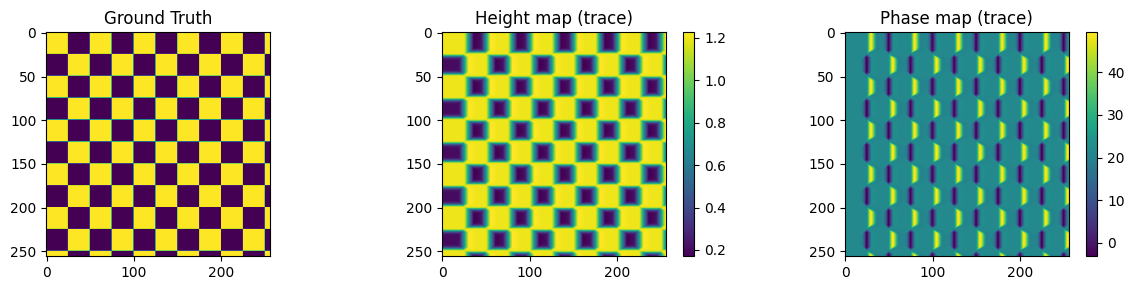

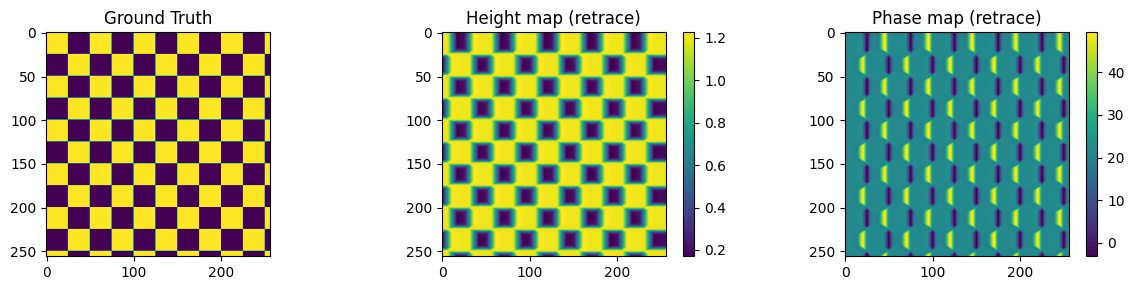

In [18]:
# This is the function to include everything:
traces = scan(image=checkerboard, kernel=tip_ideal, drive=0.5, setpoint=0.2,
          P=1, I=1e-2, z_speed=0.1, scan_speed=1, phase=True, retrace=True)

z1, ph1, z2, ph2 = traces

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z1)
im2 = ax[2].imshow(ph1)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (trace)')
ax[2].set_title('Phase map (trace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z2)
im2 = ax[2].imshow(ph2)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (retrace)')
ax[2].set_title('Phase map (retrace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

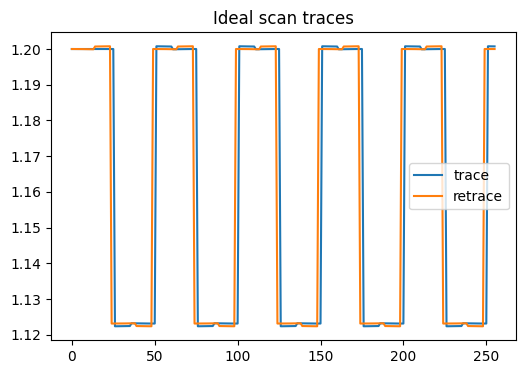

In [19]:
plt.figure(figsize=[6,4])
plt.plot(z1[100], label='trace')
plt.plot(z2[100][::-1], label='retrace')
plt.title('Ideal scan traces')
plt.legend()

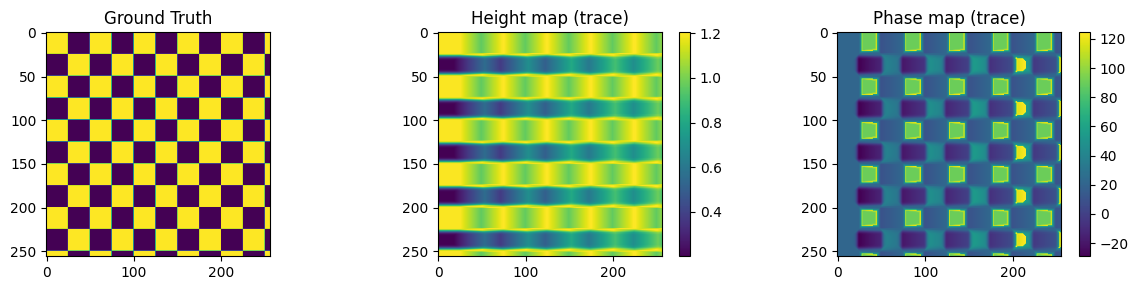

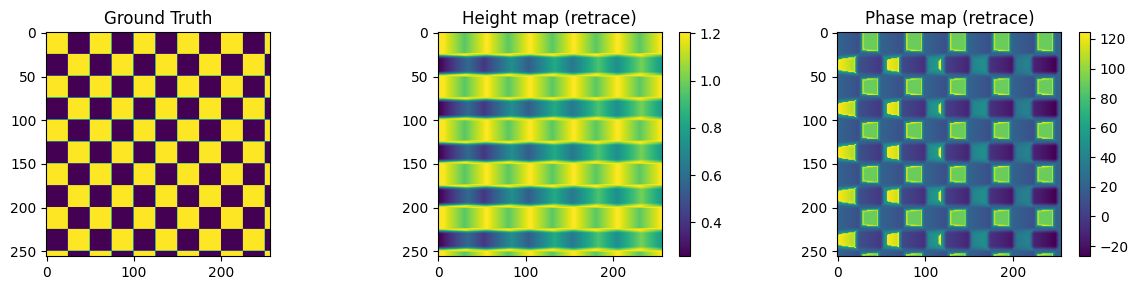

In [20]:
# If we use too small z_speed or too large scan speed, will we get parachutting effect?

# Here we have decreased the z_speed from 1e-1 to 1e-2:
traces = scan(image=checkerboard, kernel=tip_ideal, drive=0.5, setpoint=0.2,
          P=1, I=1e-2, z_speed=1e-2, scan_speed=1, phase=True, retrace=True)

z1, ph1, z2, ph2 = traces

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z1)
im2 = ax[2].imshow(ph1)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (trace)')
ax[2].set_title('Phase map (trace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z2)
im2 = ax[2].imshow(ph2)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (retrace)')
ax[2].set_title('Phase map (retrace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

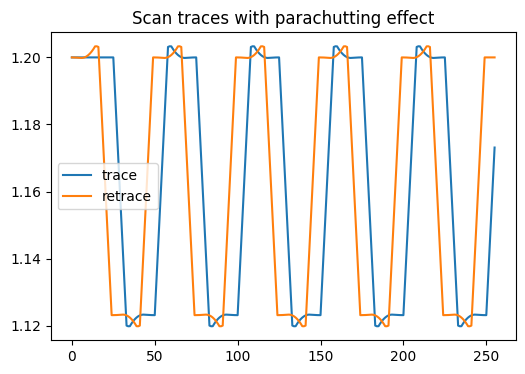

In [21]:
plt.figure(figsize=[6,4])
plt.plot(z1[100], label='trace')
plt.plot(z2[100][::-1], label='retrace')
plt.title('Scan traces with parachutting effect')
plt.legend()

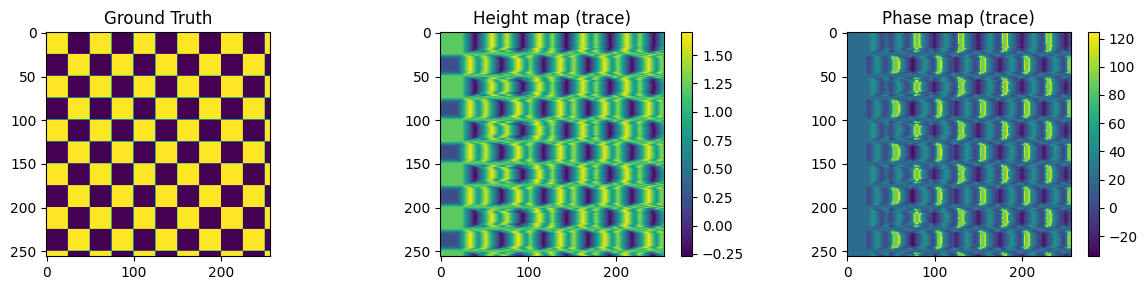

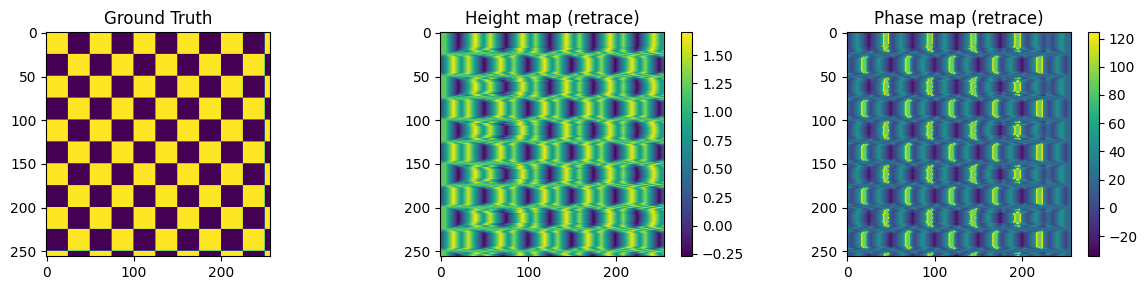

In [22]:
# If we used a too large I Gain, there will be oscillation in the map

# If we use too small z_speed, will we get parachutting effect?

# Here we have decreased the I Gain from 1e-2 to 1:
traces = scan(image=checkerboard, kernel=tip_ideal, drive=0.5, setpoint=0.2,
          P=1, I=1, z_speed=1e-1, scan_speed=1, phase=True, retrace=True)

z1, ph1, z2, ph2 = traces

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z1)
im2 = ax[2].imshow(ph1)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (trace)')
ax[2].set_title('Phase map (trace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z2)
im2 = ax[2].imshow(ph2)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (retrace)')
ax[2].set_title('Phase map (retrace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

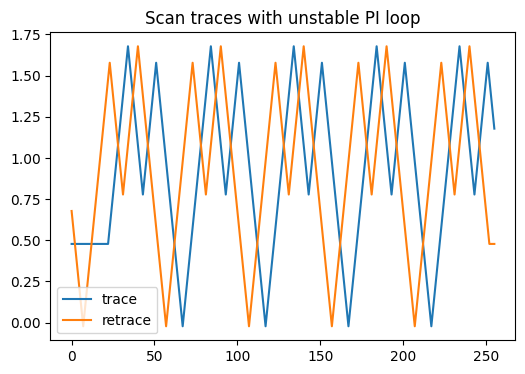

In [23]:
plt.figure(figsize=[6,4])
plt.plot(z1[128], label='trace')
plt.plot(z2[128][::-1], label='retrace')
plt.title('Scan traces with unstable PI loop')
plt.legend()

# Step-by-step use

## Adding tip effect

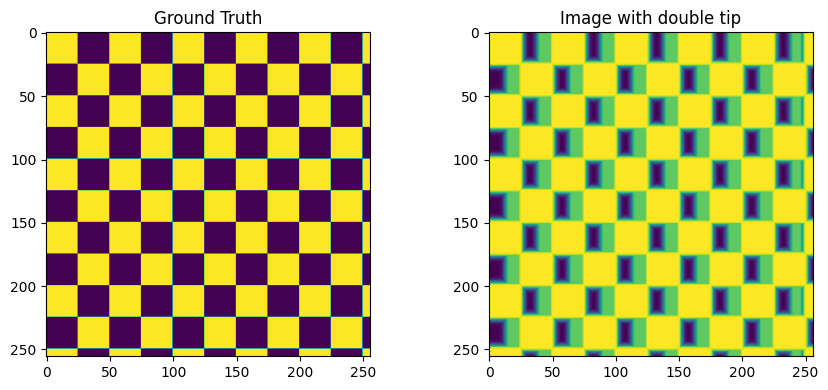

In [24]:
# Here we only consider the tip shape effect
checkerboard = generate_pattern(nx=256, ny=256, pattern='checkerboard', num=10, show=False)

kernel_size = 100
wx1 = 2.5   # x width of the probe 1
wy1 = 2.5   # y width of the probe 1
amp1 = 1  # amplitude for probe 1

wx2 = 2.5   # x width of the probe 2
wy2 = 2.5   # y width of the probe 2
amp2 = 0.75  # amplitude for probe 2

offset = [10, 0] # this one controls the separation of two tips

tip_double = generate_doubletip_kernel(kernel_size=kernel_size, offset=offset,tip1=[wx1, wy1, amp1], tip2=[wx2, wy2, amp2])

checkerboard_scan = tip_scan(checkerboard, tip_double)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(checkerboard)
ax[1].imshow(checkerboard_scan)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with double tip')

plt.tight_layout()

## Adding PI effect

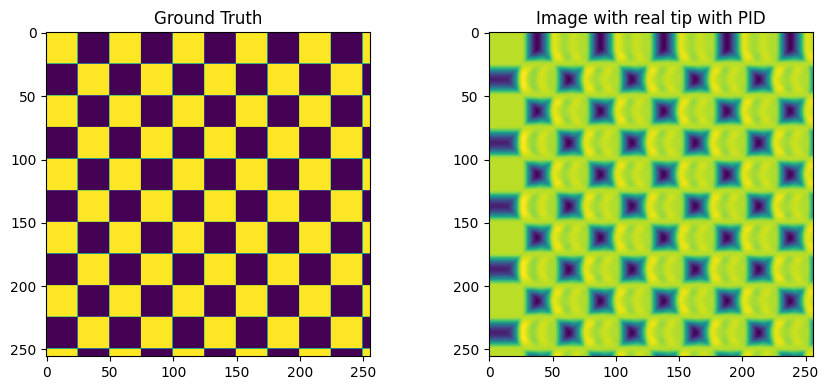

In [25]:
# Scanning with a real tip and real PID settings

tip_ideal = generate_tip_kernel(kernel_size=50, wx=5, wy=5)
checkerboard_scan = tip_scan(checkerboard, tip_ideal)
checkerboard_PI = pi_loop(checkerboard_scan, P=0.5, I=1e-1)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(checkerboard)
ax[1].imshow(checkerboard_PI)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with real tip with PID')
plt.tight_layout()

## Simulate tip change events

In [26]:
print(scanning_tip_change.__doc__)


    Simulate the scanning with tip change and/or PI setting changes.
    Input:
        img: ground truth image pattern
        kernel1: tip kernel before tip change event
        kernel2: tip kernel after tip change event. If not provided, will be the same as kernel1
        pi1: [P, I] settings for the PI before tip change event
        pi2: [P, I] settings for the PI after tip change event. If not provided, will be the same as pi1
    


In [27]:

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

# Initial tip kernel
tip_before = generate_tip_kernel(kernel_size, wx=2.5, wy=2.5, tip_height=1)

# Tip kernel after tip change -- it's shorter and more blunt
tip_after = generate_tip_kernel(kernel_size, wx=5, wy=5, tip_height=0.5)

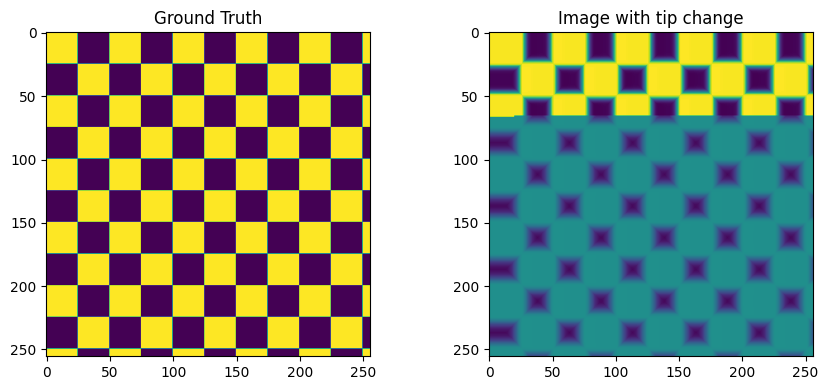

In [28]:
checkerboard_tip_change = scanning_tip_change(checkerboard, tip_before, pi1=[1, 1e-2], kernel2=tip_after, pi2=None)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(checkerboard)
ax[1].imshow(checkerboard_tip_change)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with tip change')
plt.tight_layout()

# Simulate scanning images with different tip kernels

## Starting with a single non-ideal tip

In [29]:

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

# # Initial tip kernel
# tip_before = generate_tip_kernel(kernel_size, wx=2.5, wy=2.5, tip_height=1)

# Tip kernel after tip change -- it's shorter and more blunt
tip_kernel = generate_tip_kernel(kernel_size, wx=5, wy=5, tip_height=1)

## Generate four different ground-truth patterns

In [30]:
gt_images = [checkerboard, spiral, atomic, droplets]

conv_images = []

for image in gt_images:
    conv_images.append(tip_scan(image, tip_kernel))

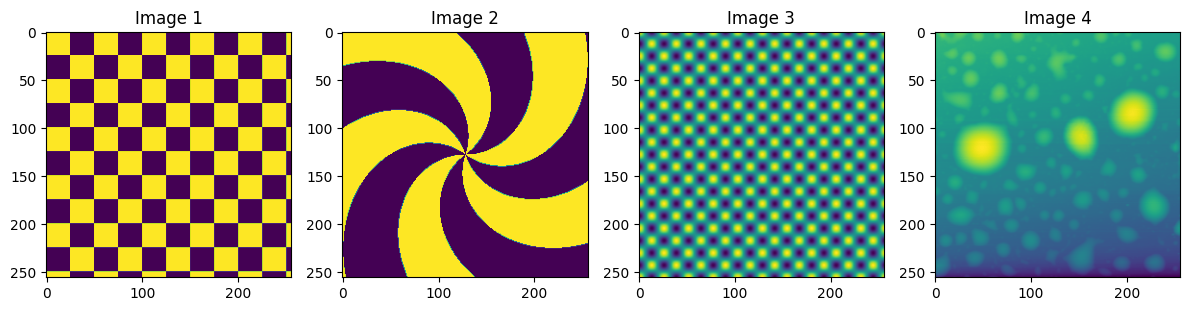

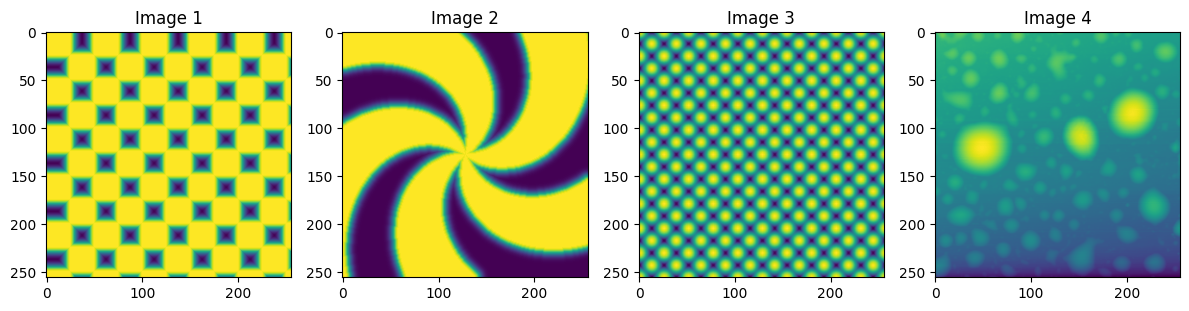

In [32]:
fig,ax=plt.subplots(1,4,figsize=[12,3])
for i in range(4):
    ax[i].imshow(gt_images[i])
    ax[i].set_title(f'Image {i+1}')
plt.tight_layout()

fig,ax=plt.subplots(1,4,figsize=[12,3])
for i in range(4):
    ax[i].imshow(conv_images[i])
    ax[i].set_title(f'Image {i+1}')
plt.tight_layout()

# ResNetModule

Here we use a resnet module - this uses 3 resnets in the intial layer followed by another resnet in the next layer
This is based on the work by: https://onlinelibrary.wiley.com/doi/full/10.1002/advs.202203957


In [65]:
# ResNetModule

import torch
import torch.nn as nn

class ResNetBlock(nn.Module):

    """
    Basic Residual block for ResNet architecture

    """

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer (if needed for skip connection)
        self.downsample = downsample

    def forward(self, x):
        identity = x  # Save the input for the skip connection

        # Pass through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Pass through the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply the downsample layer if dimensions differ
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the skip connection
        out += identity
        out = self.relu(out)

        return out



class ResNetWithUpsampling(nn.Module):
    """
    Double ResNets architecture with upsampling block
    """
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        # First ResNet block (stride=1)
        self.res_block1 = ResNetBlock(in_channels, mid_channels, stride=1)

        # MaxPool layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second ResNet block (stride=2)
        downsample = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.res_block2 = ResNetBlock(mid_channels, out_channels, stride=2, downsample=downsample)

        # Upsample layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final 1x1 convolution to match target dimensions
        self.final_conv = nn.Conv2d(out_channels + mid_channels, 1, kernel_size=1)

    def forward(self, x):
        # Pass through first ResNet block
        out1 = self.res_block1(x)  # Shape: [batch_size, mid_channels, 256, 256]

        # Downsample with MaxPool
        out1 = self.maxpool(out1)  # Shape: [batch_size, mid_channels, 128, 128]

        # Upsample after MaxPool
        out1_upsampled = self.upsample(out1)  # Shape: [batch_size, mid_channels, 256, 256]

        # Pass through second ResNet block
        out2 = self.res_block2(out1)  # Shape: [batch_size, out_channels, 64, 64]

        # Upsample the output of the second ResNet block
        out2_upsampled = self.upsample(out2)  # Shape: [batch_size, out_channels, 128, 128]
        out2_upsampled = self.upsample(out2_upsampled)  # Shape: [batch_size, out_channels, 256, 256]

        # Concatenate outputs along the channel dimension
        out = torch.cat([out1_upsampled, out2_upsampled], dim=1)  # Shape: [batch_size, mid_channels + out_channels, 256, 256]

        # Final 1x1 convolution to reduce to single channel
        out = self.final_conv(out)  # Shape: [batch_size, 1, 256, 256]

        return out





class ResNetModule(nn.Module):


    def __init__(self, input_channels: int, output_channels: int, res_depth: int):
        super().__init__()
        res_module = []

        for i in range(res_depth):
            input_channels = output_channels if i > 0 else input_channels

            res_module.append(ResNetBlock(input_channels, output_channels))

        self.res_module = nn.Sequential(*res_module)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines a forward pass
        """
        x = self.res_module(x)

        return x

class ResNetModuleWithUpsampling(nn.Module):
    """
    Double ResNet module architecture with upsampling block
    """
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        # First ResNet block (stride=1)
        self.res_block1 = ResNetModule(in_channels, mid_channels, res_depth=3)

        # MaxPool layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second ResNet block (stride=2)
        downsample = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.res_block2 = ResNetBlock(mid_channels, out_channels, stride=2, downsample=downsample)

        # Upsample layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final 1x1 convolution to match target dimensions
        self.final_conv = nn.Conv2d(out_channels + mid_channels, 1, kernel_size=1)

    def forward(self, x):
        # Pass through first ResNet block
        out1 = self.res_block1(x)  # Shape: [batch_size, mid_channels, 256, 256]

        # Downsample with MaxPool
        out1 = self.maxpool(out1)  # Shape: [batch_size, mid_channels, 128, 128]

        # Upsample after MaxPool
        out1_upsampled = self.upsample(out1)  # Shape: [batch_size, mid_channels, 256, 256]

        # Pass through second ResNet block
        out2 = self.res_block2(out1)  # Shape: [batch_size, out_channels, 64, 64]

        # Upsample the output of the second ResNet block
        out2_upsampled = self.upsample(out2)  # Shape: [batch_size, out_channels, 128, 128]
        out2_upsampled = self.upsample(out2_upsampled)  # Shape: [batch_size, out_channels, 256, 256]

        # Concatenate outputs along the channel dimension
        out = torch.cat([out1_upsampled, out2_upsampled], dim=1)  # Shape: [batch_size, mid_channels + out_channels, 256, 256]

        # Final 1x1 convolution to reduce to single channel
        out = self.final_conv(out)  # Shape: [batch_size, 1, 256, 256]

        return out


In [82]:
from torch.utils.data import Dataset, DataLoader

class PairedImageDataset(Dataset):
    def __init__(self, gt_images, conv_images, transform=None):
        """
        Args:
            gt_images (list): List of ground truth images.
            conv_images (list): List of distorted images.
            transform (callable, optional): Optional transform to apply to both images.
        """
        self.gt_images = gt_images
        self.conv_images = conv_images
        self.transform = transform

        assert len(gt_images) == len(conv_images), "Mismatch in number of ground truth and distorted images."

    def __len__(self):
        return len(self.gt_images)

    def __getitem__(self, idx):
        # Get the ground truth and distorted images
        gt_image = self.gt_images[idx]
        conv_image = self.conv_images[idx]

        # Apply any transformations if provided
        if self.transform:
            gt_image = self.transform(gt_image)
            conv_image = self.transform(conv_image)

        return conv_image, gt_image


import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Transformation to convert NumPy array to PyTorch tensor
transform = transforms.Compose([
    transforms.ToPILImage(),           # Convert NumPy array to PIL Image
    transforms.Resize((256, 256)),     # Resize to a fixed size
    #transforms.RandomHorizontalFlip(p = 0.3),
    transforms.ToTensor(),             # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])


# Create the dataset
dataset = PairedImageDataset(gt_images, conv_images, transform=transform)

# Create the DataLoader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [67]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Initialize the resnetmodel
model = ResNetModuleWithUpsampling(in_channels=1, mid_channels=64, out_channels=128).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Or other appropriate loss, e.g., MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def train_model(model, dataloader, num_epochs, criterion, optimizer):
    model.train()
    for epoch in range(num_epochs):
        for distorted, ground_truth in dataloader:
            distorted, ground_truth = distorted.to(device), ground_truth.to(device)

            # Forward pass
            outputs = model(distorted)
            loss = criterion(outputs, ground_truth)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Assume DataLoader `train_loader` is already prepared
#train_model(model, train_loader, num_epochs=100, criterion=criterion, optimizer=optimizer)


Epoch [1/100],Loss: 0.6884
Epoch [2/100],Loss: 1.8604
Epoch [3/100],Loss: 3.1408
Epoch [4/100],Loss: 0.3203
Epoch [5/100],Loss: 0.3831
Epoch [6/100],Loss: 0.2281
Epoch [7/100],Loss: 0.1290
Epoch [8/100],Loss: 0.1748
Epoch [9/100],Loss: 0.1185
Epoch [10/100],Loss: 0.0992
Epoch [11/100],Loss: 0.1030
Epoch [12/100],Loss: 0.0982
Epoch [13/100],Loss: 0.0810
Epoch [14/100],Loss: 0.0766
Epoch [15/100],Loss: 0.0780
Epoch [16/100],Loss: 0.0768
Epoch [17/100],Loss: 0.0683
Epoch [18/100],Loss: 0.0642
Epoch [19/100],Loss: 0.0630
Epoch [20/100],Loss: 0.0639
Epoch [21/100],Loss: 0.0615
Epoch [22/100],Loss: 0.0581
Epoch [23/100],Loss: 0.0559
Epoch [24/100],Loss: 0.0550
Epoch [25/100],Loss: 0.0549
Epoch [26/100],Loss: 0.0534
Epoch [27/100],Loss: 0.0517
Epoch [28/100],Loss: 0.0507
Epoch [29/100],Loss: 0.0504
Epoch [30/100],Loss: 0.0502
Epoch [31/100],Loss: 0.0492
Epoch [32/100],Loss: 0.0483
Epoch [33/100],Loss: 0.0474
Epoch [34/100],Loss: 0.0470
Epoch [35/100],Loss: 0.0465
Epoch [36/100],Loss: 0.0458
E

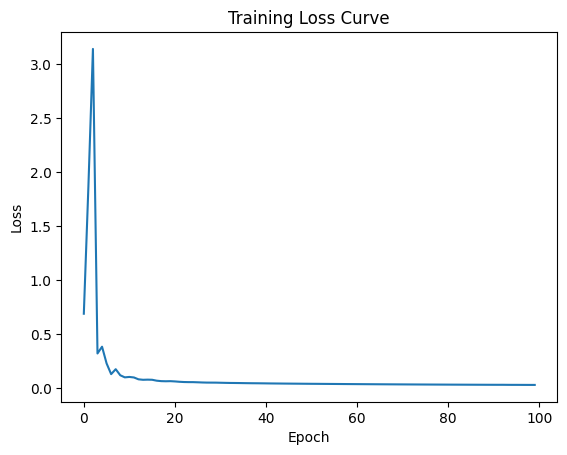

In [68]:
import matplotlib.pyplot as plt

def train_model(model, dataloader, num_epochs, criterion, optimizer):
    model.train()
    loss_values = []  # Store loss values here
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for distorted, ground_truth in dataloader:
            distorted, ground_truth = distorted.to(device), ground_truth.to(device)

            # Forward pass
            outputs = model(distorted)
            loss = criterion(outputs, ground_truth)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_values.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}],Loss: {avg_loss:.4f}")

    # Plot training loss curve
    plt.plot(loss_values)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()
# Assume DataLoader `train_loader` is already prepared
train_model(model, train_loader, num_epochs=100, criterion=criterion, optimizer=optimizer)

In [69]:
import matplotlib.pyplot as plt

def visualize_results(model, dataloader):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Get a batch of distorted and ground truth images
        for distorted, ground_truth in dataloader:
            distorted, ground_truth = distorted.to(device), ground_truth.to(device)

            # Forward pass: get model predictions
            outputs = model(distorted)

            # Visualize the first image in the batch
            plt.figure(figsize=(12, 4))

            # Input Image
            plt.subplot(1, 3, 1)
            plt.imshow(distorted[0].cpu().numpy()[0], cmap='gray')
            plt.title("Input Image (Distorted)")

            # Ground Truth
            plt.subplot(1, 3, 2)
            plt.imshow(ground_truth[0].cpu().numpy()[0], cmap='gray')
            plt.title("Ground Truth")

            # Model Output
            plt.subplot(1, 3, 3)
            plt.imshow(outputs[0].cpu().numpy()[0], cmap='gray')
            plt.title("Model Output")

            plt.show()
            # break  # Show only one batch


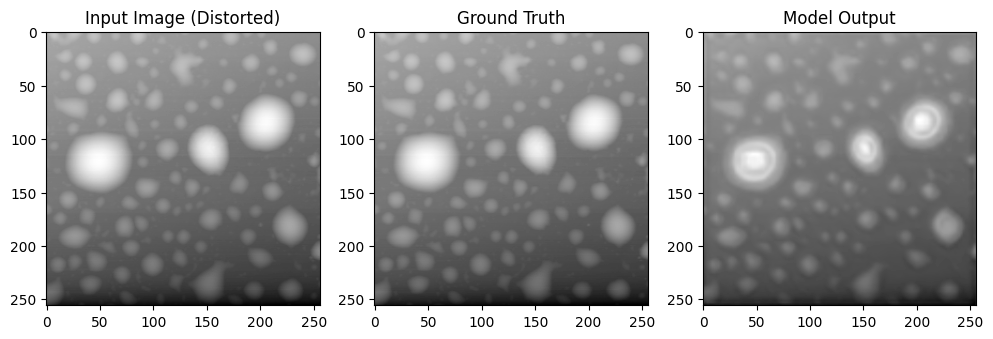

In [70]:
visualize_results(model, train_loader)


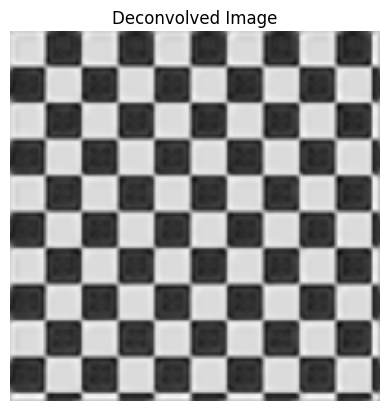

In [71]:
# Assume 'conv_images[0]' is the image you want to process
image = transform(conv_images[0])  # Apply the transform to get the tensor

# Move the input image to the same device as the model
image = image.to(device)

# Apply the trained model to recover the image (deconvolution)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output_image = model(image.unsqueeze(0))  # Add batch dimension (1, 1, H, W)

# Convert the output back to a numpy array for visualization
output_image_np = output_image.cpu().numpy().squeeze(0)  # Remove batch dimension

# Display the deconvolved image
import matplotlib.pyplot as plt
plt.imshow(output_image_np[0], cmap='gray')  # Only show the single channel
plt.title("Deconvolved Image")
plt.axis("off")
plt.show()


## Generate different types of ground-truth images and tip kernels

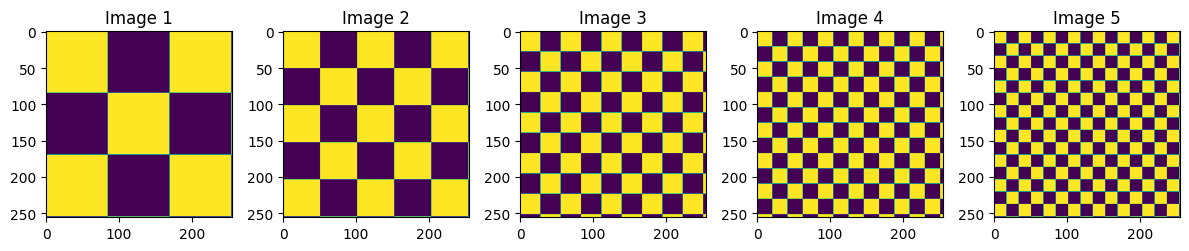

In [72]:
# Checkerboards with different sizes

sizes = [3, 5, 9, 12, 15]

checkerboards = []
for size in sizes:
    checkerboards.append(generate_pattern(nx=256, ny=256, pattern='checkerboard', num=size, show=False))

fig, ax=plt.subplots(1,5,figsize=[12,3])
for i in range(5):
    ax[i].imshow(checkerboards[i])
    ax[i].set_title(f'Image {i+1}')
plt.tight_layout()

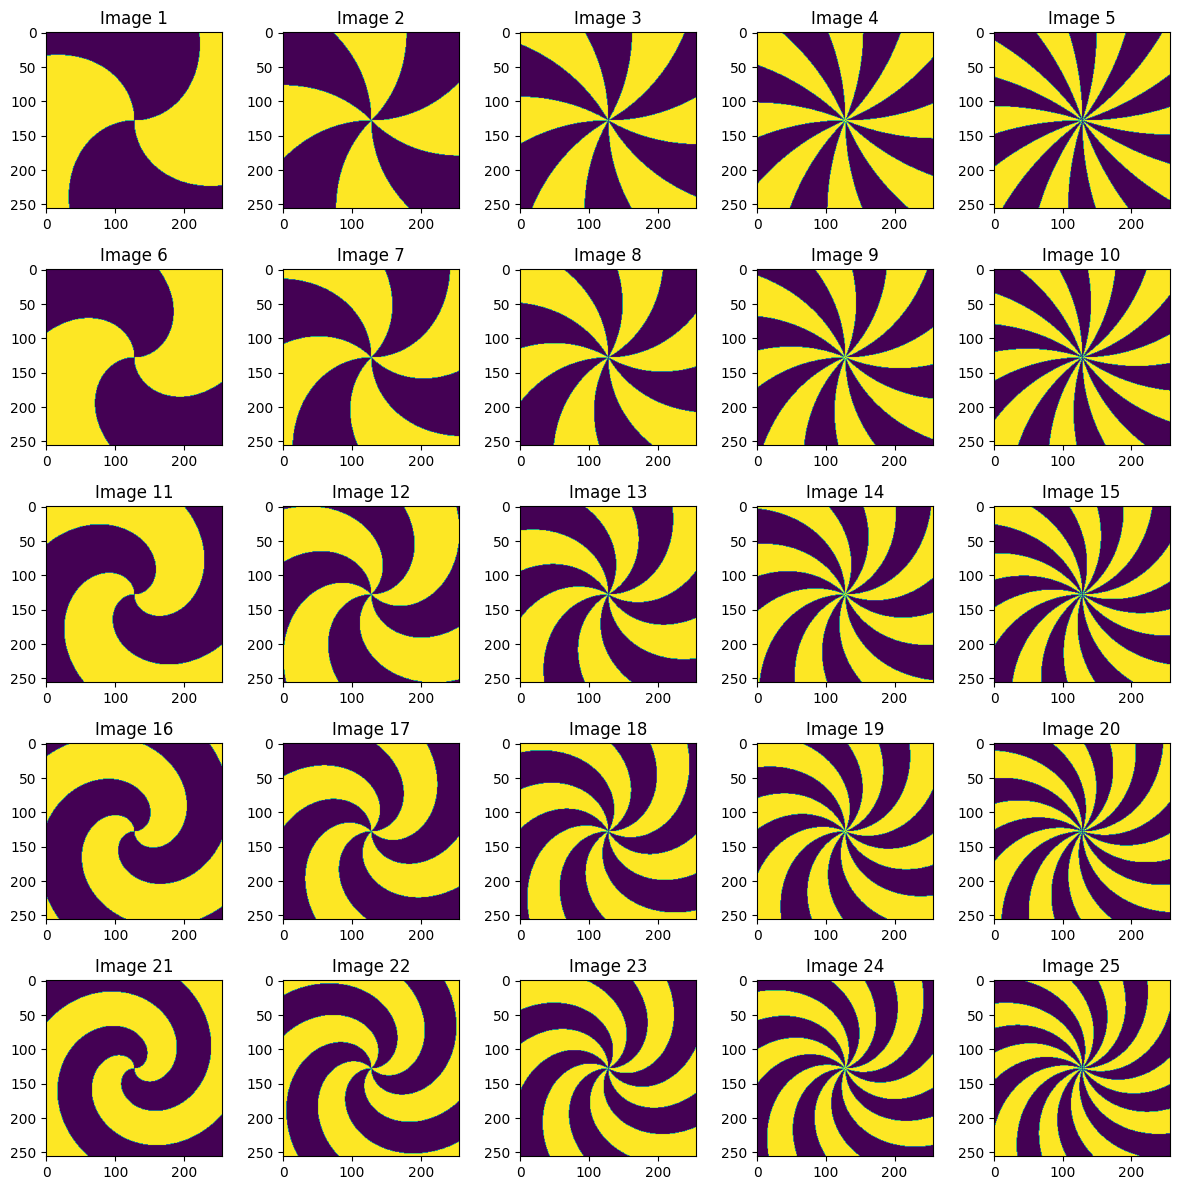

In [73]:
# Checkerboards with different sizes

sizes = [3, 5, 9, 12, 15]

spirals = []

turns = [2, 4, 6, 8, 10]

for size in sizes:
    for j in range(len(turns)):
        spirals.append(generate_pattern(nx=256, ny=256, pattern='spiral', num=size, turns=turns[j], show=False))

fig, ax=plt.subplots(5,5,figsize=[12,12])
for i in range(25):
    ax.flatten()[i].imshow(spirals[i])
    ax.flatten()[i].set_title(f'Image {i+1}')
plt.tight_layout()

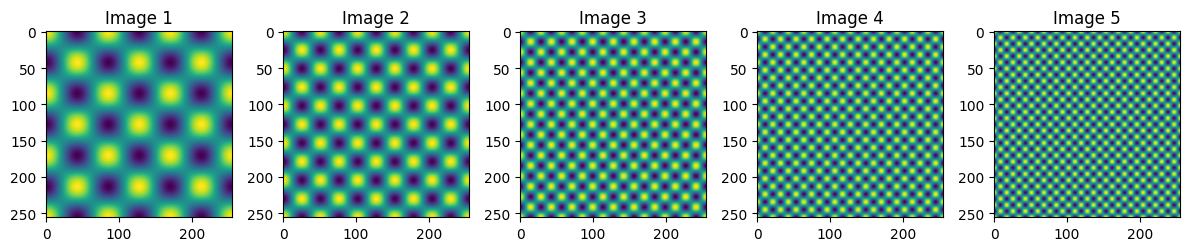

In [74]:
# Atomics with different sizes

sizes = [3, 5, 9, 12, 15]

atomics = []
for size in sizes:
    atomics.append(generate_pattern(nx=256, ny=256, pattern='atomic', num=size, show=False))

fig, ax=plt.subplots(1,5,figsize=[12,3])
for i in range(5):
    ax[i].imshow(atomics[i])
    ax[i].set_title(f'Image {i+1}')
plt.tight_layout()

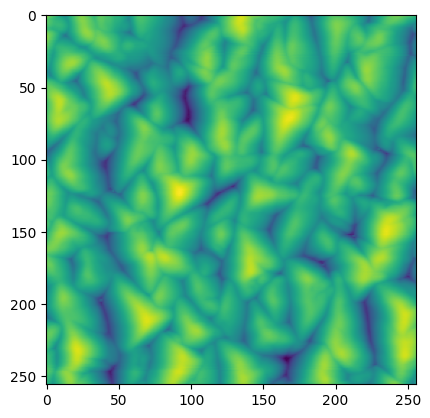

In [75]:
topo = np.loadtxt('topo.txt')
plt.imshow(topo)

## Different tip kernels

In [76]:
# Single tips with different sharpness

kernel_size = 100

widths = [2.5, 5, 10, 20, 30]

# # Initial tip kernel
# tip_before = generate_tip_kernel(kernel_size, wx=2.5, wy=2.5, tip_height=1)

# Tip kernel after tip change -- it's shorter and more blunt

single_tips = []
for width in widths:
    single_tips.append(generate_tip_kernel(kernel_size, wx=width, wy=width, tip_height=1))

In [77]:
# Double tip with different separations



## Simulate the tip size effects

In [78]:
gt_images = []
conv_images = []

for image in checkerboards:
    for j in range(len(single_tips)):
        gt_images.append(image)
        conv_images.append(tip_scan(image, single_tips[j]))

for image in atomics:
    for j in range(len(single_tips)):
        gt_images.append(image)
        conv_images.append(tip_scan(image, single_tips[j]))

for image in spirals:
    for j in range(len(single_tips)):
        gt_images.append(image)
        conv_images.append(tip_scan(image, single_tips[j]))

for j in range(len(single_tips)):
    gt_images.append(topo)
    conv_images.append(tip_scan(topo, single_tips[j]))


## Train the ResNetModules

In [79]:
# Create the dataset
dataset = PairedImageDataset(gt_images, conv_images, transform=transform)

# Create the DataLoader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/100], Loss: 0.7450
Epoch [2/100], Loss: 0.2578
Epoch [3/100], Loss: 0.2234
Epoch [4/100], Loss: 0.2320
Epoch [5/100], Loss: 0.1783
Epoch [6/100], Loss: 0.1783
Epoch [7/100], Loss: 0.1403
Epoch [8/100], Loss: 0.1367
Epoch [9/100], Loss: 0.1386
Epoch [10/100], Loss: 0.1392
Epoch [11/100], Loss: 0.1297
Epoch [12/100], Loss: 0.1280
Epoch [13/100], Loss: 0.1416
Epoch [14/100], Loss: 0.1379
Epoch [15/100], Loss: 0.1231
Epoch [16/100], Loss: 0.1110
Epoch [17/100], Loss: 0.1016
Epoch [18/100], Loss: 0.1070
Epoch [19/100], Loss: 0.1372
Epoch [20/100], Loss: 0.1356
Epoch [21/100], Loss: 0.1166
Epoch [22/100], Loss: 0.1138
Epoch [23/100], Loss: 0.1231
Epoch [24/100], Loss: 0.1053
Epoch [25/100], Loss: 0.0983
Epoch [26/100], Loss: 0.0965
Epoch [27/100], Loss: 0.0904
Epoch [28/100], Loss: 0.0849
Epoch [29/100], Loss: 0.1220
Epoch [30/100], Loss: 0.0991
Epoch [31/100], Loss: 0.0865
Epoch [32/100], Loss: 0.0955
Epoch [33/100], Loss: 0.0836
Epoch [34/100], Loss: 0.0856
Epoch [35/100], Loss: 0

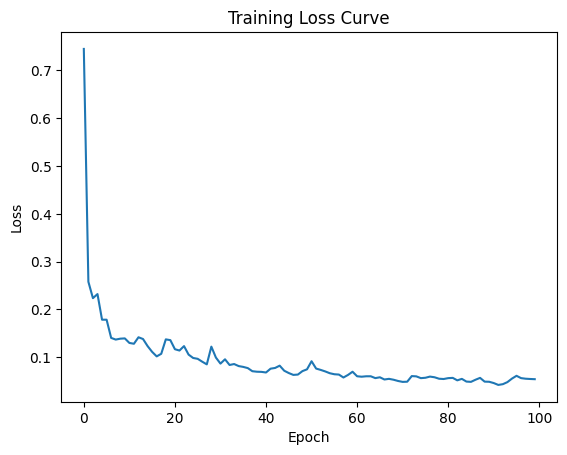

In [81]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize ResNet model
model = ResNetModuleWithUpsampling(in_channels = 1, mid_channels = 64, out_channels = 128).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Or other appropriate loss, e.g., MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

import matplotlib.pyplot as plt

def train_model(model, dataloader, num_epochs, criterion, optimizer):
    model.train()
    loss_values = []  # Store loss values here
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for distorted, ground_truth in dataloader:
            distorted, ground_truth = distorted.to(device), ground_truth.to(device)

            # Forward pass
            outputs = model(distorted)
            loss = criterion(outputs, ground_truth)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_values.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Plot training loss curve
    plt.plot(loss_values)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()


# Assume DataLoader `train_loader` is already prepared
train_model(model, train_loader, num_epochs=100, criterion=criterion, optimizer=optimizer)


In [83]:
def deconvolution(model,img):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        image = transform(img)  # Apply the transform to get the tensor
        image = image.to(device)
        output_image = model(image.unsqueeze(0))  # Add batch dimension (1, 1, H, W)
        output_image_np = output_image.cpu().numpy().squeeze(0)  # Remove batch dimension
        return output_image_np

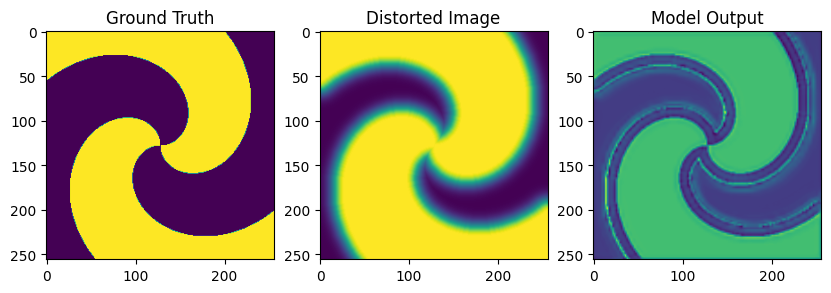

In [84]:
index = 102

image = transform(conv_images[index])  # Apply the transform to get the tensor

# Convert the output back to a numpy array for visualization
output_image_np = deconvolution(model, image)

# Display the deconvolved image
import matplotlib.pyplot as plt
fig, ax=plt.subplots(1,3,figsize=[10,3])
ax[0].imshow(gt_images[index])
ax[1].imshow(conv_images[index])
ax[2].imshow(output_image_np[0])  # Only show the single channel

ax[0].set_title("Ground Truth")
ax[1].set_title("Distorted Image")
ax[2].set_title("Model Output")
plt.show()

In [ ]:
len(gt_images)

180

Here are the goals for this tip deconvolution project:

1. Get better deconvolution quality
2. Original paper only focusd on deconvolution of sharp features with finite tip-size effect. Can we extent it to more complicated profile patterns and tip shapes (like asymmetric tip shape, double tips with different separation and relative heights)?
3. Can we improve the results with more advanced machine learning algorithms?

## Add more types of tip shapes (and artifacts)